In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import scipy.stats as stats
from sklearn.cluster import KMeans
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

# Common base URL for raw GitHub data files
base_url = 'https://raw.githubusercontent.com/SriniHProject/ecommerce-sales-insights/main/data/'

# Reading CSV files using the base URL
customers_df = pd.read_csv(base_url + 'Customers_Data.csv')
sales_df = pd.read_csv(base_url + 'Online_Sales.csv')
coupons_df = pd.read_csv(base_url + 'Discount_Coupon.csv')
tax_df = pd.read_csv(base_url + 'Tax_Amount.csv')
marketing_df = pd.read_csv(base_url + 'Marketing_Spend.csv')


print("Sales data shape:", sales_df.shape)
print("Customers data shape:", customers_df.shape)
print("Coupons data shape:", coupons_df.shape)
print("Marketing data shape:", marketing_df.shape)
print("Tax data shape:", tax_df.shape)




for df_name, df in zip(['Sales', 'Customers', 'Coupons', 'Marketing', 'Tax'],
                       [sales_df, customers_df, coupons_df, marketing_df, tax_df]):
    print(f"\nMissing values in {df_name} dataset:")
    print(df.isnull().sum())


def convert_date_col_to_datetime():
    # Convert date columns to datetime
    sales_df['Transaction_Date'] = pd.to_datetime(sales_df['Transaction_Date'])
    marketing_df['Date'] = pd.to_datetime(marketing_df['Date'])


def convert_tax_percentages():
    """Convert percentage strings in tax dataframe to numeric decimals"""
    tax_df['GST'] = tax_df['GST'].str.replace('%', '').astype(float) / 100


def extract_date_components():
    """Extract and add various date components to sales data"""
    sales_df['Year'] = sales_df['Transaction_Date'].dt.year
    sales_df['Month'] = sales_df['Transaction_Date'].dt.month
    sales_df['Month_Name'] = sales_df['Transaction_Date'].dt.strftime('%b')
    sales_df['Day'] = sales_df['Transaction_Date'].dt.day
    sales_df['Day_of_Week'] = sales_df['Transaction_Date'].dt.dayofweek
    sales_df['Day_Name'] = sales_df['Transaction_Date'].dt.strftime('%a')
    sales_df['Quarter'] = sales_df['Transaction_Date'].dt.quarter


def calculate_revenue():
    """Calculate revenue and total price including delivery charges"""
    sales_df['Revenue'] = sales_df['Quantity'] * sales_df['Avg_Price']
    sales_df['Total_Price'] = sales_df['Revenue'] + sales_df['Delivery_Charges']


# Merge datasets for comprehensive analysis
def prepare_coupon_month_matching():
    """Convert coupon months to numeric for matching"""
    coupons_df['Month_Num'] = pd.to_datetime(coupons_df['Month'], format='%b').dt.month


def merge_customer_and_sales_data():
    """Merge sales data with customer information"""
    return pd.merge(sales_df, customers_df, on='CustomerID', how='left')


def apply_coupon_discounts(df):
    """Apply appropriate coupon discounts to transactions"""

    def merge_with_coupon_info(row):
        if row['Coupon_Status'] == 'Yes':
            matching_coupons = coupons_df[(coupons_df['Month_Num'] == row['Month']) &
                                          (coupons_df['Product_Category'] == row['Product_Cateogry'])]
            if not matching_coupons.empty:
                return matching_coupons['Discount_pct'].values[0]
        return 0

    df['Discount_pct'] = df.apply(merge_with_coupon_info, axis=1)
    return df


def merge_tax_information(df):
    """Merge tax rates with transaction data"""
    return pd.merge(df, tax_df, left_on='Product_Category', right_on='Product_Category', how='left')


def calculate_final_prices(df):
    """Calculate tax amounts and final prices"""
    df['Tax_Amount'] = df['Revenue'] * df['GST'] / 100
    df['Final_Price'] = df['Total_Price'] + df['Tax_Amount']
    return df


def aggregate_and_merge_marketing_data(df):
    """
    Aggregate sales data by date and merge with marketing data
    Args:
        df: Processed sales dataframe with Transaction_Date column
    Returns:
        Merged dataframe with sales and marketing metrics
    """
    # Aggregate daily sales
    daily_sales = df.groupby('Transaction_Date').agg(
        Total_Revenue=('Revenue', 'sum'),
        Order_Count=('Transaction_ID', 'nunique')
    ).reset_index()

    # Merge with marketing data
    merged_df = pd.merge(daily_sales, marketing_df,
                         left_on='Transaction_Date',
                         right_on='Date',
                         how='left')
    return merged_df


convert_date_col_to_datetime()
convert_tax_percentages()
extract_date_components()
calculate_revenue()

# Execute the data merging pipeline
prepare_coupon_month_matching()
sales_customers_df = merge_customer_and_sales_data()
sales_customers_df = apply_coupon_discounts(sales_customers_df)
sales_customers_df = merge_tax_information(sales_customers_df)
sales_customers_df = calculate_final_prices(sales_customers_df)


Sales data shape: (52924, 10)
Customers data shape: (1468, 4)
Coupons data shape: (204, 4)
Marketing data shape: (365, 3)
Tax data shape: (20, 2)

Missing values in Sales dataset:
CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
dtype: int64

Missing values in Customers dataset:
CustomerID       0
Gender           0
Location         0
Tenure_Months    0
dtype: int64

Missing values in Coupons dataset:
Month               0
Product_Category    0
Coupon_Code         0
Discount_pct        0
dtype: int64

Missing values in Marketing dataset:
Date             0
Offline_Spend    0
Online_Spend     0
dtype: int64

Missing values in Tax dataset:
Product_Category    0
GST                 0
dtype: int64


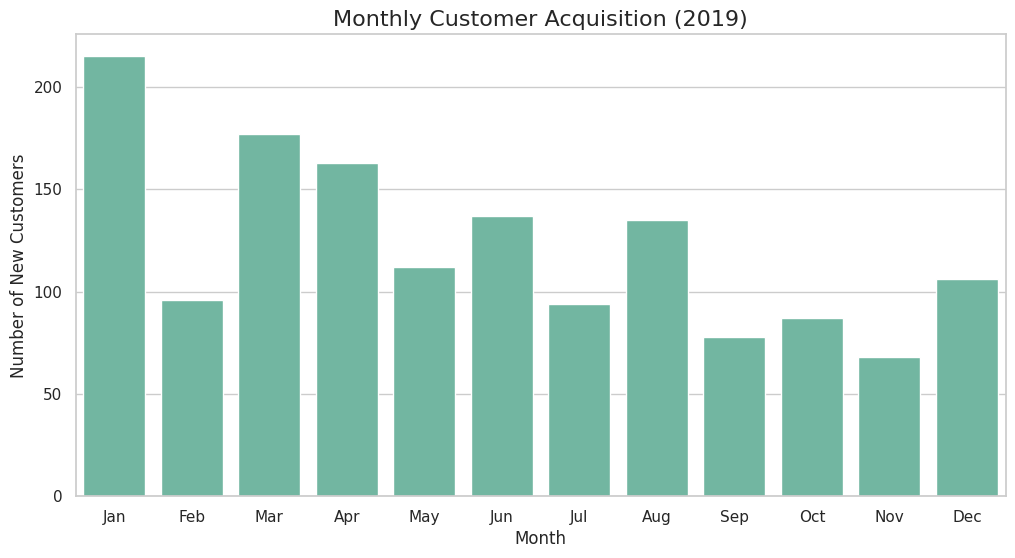

Month with highest acquisition: Jan with 215 new customers
Month with lowest acquisition: Nov with 68 new customers
Coefficient of variation: 0.36 - high cv indicates customer acquisition is more volatile from month to month. variability


In [5]:
def ques_1_2_acquisition():
    global sales_marketing_df, first_purchase, first_purchase
    # Execute marketing data processing
    sales_marketing_df = aggregate_and_merge_marketing_data(sales_customers_df)
    first_purchase = sales_df.groupby('CustomerID')['Transaction_Date'].min().reset_index()
    first_purchase.columns = ['CustomerID', 'First_Purchase_Date']
    # Add acquisition month information
    first_purchase['Acquisition_Month'] = first_purchase['First_Purchase_Date'].dt.month
    first_purchase['Acquisition_Month_Name'] = first_purchase['First_Purchase_Date'].dt.strftime('%b')
    # Count new customers by month
    monthly_acquisition = first_purchase.groupby(['Acquisition_Month', 'Acquisition_Month_Name']).size().reset_index(
        name='New_Customers')
    monthly_acquisition = monthly_acquisition.sort_values('Acquisition_Month')
    # Set Seaborn theme and palette
    sns.set_theme(style="whitegrid", palette="Set2")
    # Set plot size and font size
    plt.figure(figsize=(12, 6))
    plt.rcParams['font.size'] = 12
    # Plot monthly acquisition
    sns.barplot(
        x='Acquisition_Month_Name',
        y='New_Customers',
        data=monthly_acquisition
    )
    # Add titles and labels
    plt.title('Monthly Customer Acquisition (2019)', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Number of New Customers')
    plt.show()
    # Identify highest and lowest months
    highest_month = monthly_acquisition.loc[monthly_acquisition['New_Customers'].idxmax()]
    lowest_month = monthly_acquisition.loc[monthly_acquisition['New_Customers'].idxmin()]
    print(
        f"Month with highest acquisition: {highest_month['Acquisition_Month_Name']} with {highest_month['New_Customers']} new customers")
    print(
        f"Month with lowest acquisition: {lowest_month['Acquisition_Month_Name']} with {lowest_month['New_Customers']} new customers")
    # Check consistency across months
    acquisition_cv = monthly_acquisition['New_Customers'].std() / monthly_acquisition['New_Customers'].mean()
    print(
        f"Coefficient of variation: {acquisition_cv:.2f} - {'high cv indicates customer acquisition is more volatile from month to month.' if acquisition_cv > 0.3 else 'moderate' if acquisition_cv > 0.1 else 'low'} variability")

ques_1_2_acquisition()


   CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679       2019-01-01  GGOENEBJ079499   
1       17850           16680       2019-01-01  GGOENEBJ079499   
2       17850           16681       2019-01-01  GGOEGFKQ020399   
3       17850           16682       2019-01-01  GGOEGAAB010516   
4       17850           16682       2019-01-01  GGOEGBJL013999   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  Year  Month  \
0         1     153.71               6.5          Used  2019      1   
1         1     153.71

<ipython-input-60-77c579426b77>:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  monthly_activity = monthly_activity.applymap(lambda x: 1 if x > 0 else 0)


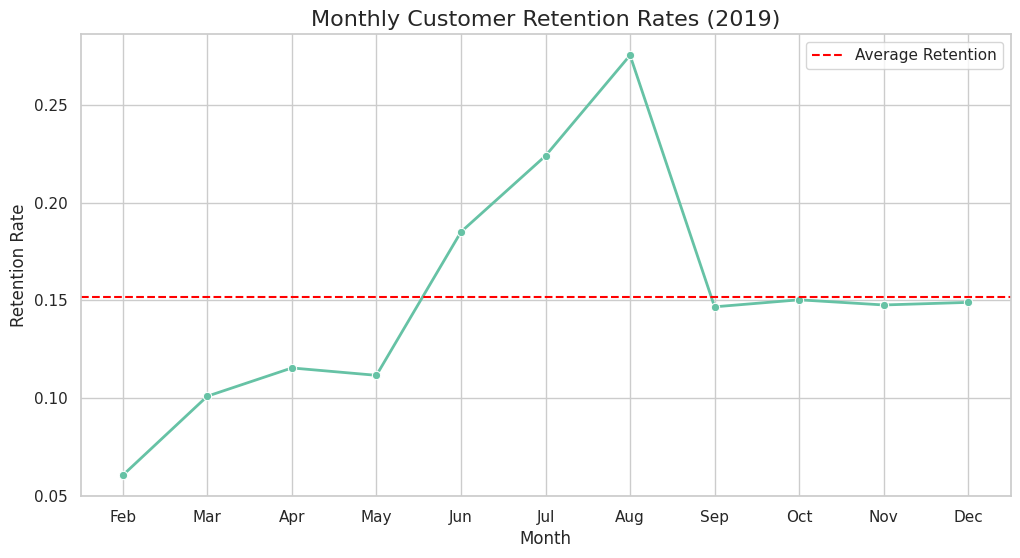

In [ ]:

def calculate_retention(sales_df, months_to_analyze=12):
    """
    Calculate retention rate by month
    Retention rate = (Active customers who made a purchase in previous month and current month) /
                    (Total customers who made a purchase in previous month)
    """
    # Create a pivot table with months as columns and customer IDs as rows
    monthly_activity = pd.crosstab(
        index=sales_df['CustomerID'],
        columns=sales_df['Month'],
        values=sales_df['Transaction_ID'],
        aggfunc='count'
    ).fillna(0)
    print(sales_df.head())

    # print(monthly_activity.head())
    # Convert to binary activity indicator (1 = active, 0 = inactive)
    monthly_activity = monthly_activity.applymap(lambda x: 1 if x > 0 else 0)
    # print(monthly_activity.head())

    # Calculate retention for each month
    retention_rates = {}
    for month in range(2, months_to_analyze + 1):
        if month in monthly_activity.columns and (month - 1) in monthly_activity.columns:
            # Customers active in previous month
            prev_month_active = monthly_activity[month - 1] == 1
            prev_month_count = prev_month_active.sum()

            # Customers active in both previous and current month
            retained_count = ((monthly_activity[month - 1] == 1) & (monthly_activity[month] == 1)).sum()

            # Calculate retention rate
            if prev_month_count > 0:
                retention_rate = retained_count / prev_month_count
                retention_rates[month] = retention_rate
    # print(retention_rates)
    return pd.DataFrame(list(retention_rates.items()), columns=['Month', 'Retention_Rate'])

def ques_3_4_retention():


    # Calculate monthly retention rates
    retention_df = calculate_retention(sales_df)
    # Map month numbers to names
    month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                   7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    retention_df['Month_Name'] = retention_df['Month'].map(month_names)
    # Visualize retention rates
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Month_Name', y='Retention_Rate', data=retention_df, marker='o', linewidth=2)
    plt.title('Monthly Customer Retention Rates (2019)', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Retention Rate')
    plt.axhline(retention_df['Retention_Rate'].mean(), color='red', linestyle='--', label='Average Retention')
    plt.legend()
    # Identify highest and lowest retention periods
    highest_retention = retention_df.loc[retention_df['Retention_Rate'].idxmax()]
    lowest_retention = retention_df.loc[retention_df['Retention_Rate'].idxmin()]
    print(
        f"Month with highest retention: {highest_retention['Month_Name']} with {highest_retention['Retention_Rate']:.2f} retention rate")
    print(
        f"Month with lowest retention: {lowest_retention['Month_Name']} with {lowest_retention['Retention_Rate']:.2f} retention rate")
    # Analyze customer behavior during high retention months
    high_retention_month = highest_retention['Month']
    high_month_transactions = sales_df[sales_df['Month'] == high_retention_month]
    # Analyze product categories, average order value, coupon usage during high retention month
    high_month_stats = {
        'Top Categories': high_month_transactions['Product_Category'].value_counts().head(3).index.tolist(),
        'Average Order Value': high_month_transactions.groupby('Transaction_ID')['Revenue'].sum().mean(),
        'Coupon Usage Rate': high_month_transactions['Coupon_Status'].value_counts(normalize=True).get('Yes', 0),
        'Average Items Per Order': high_month_transactions.groupby('Transaction_ID')['Quantity'].sum().mean()
    }
    print("Characteristics of high-retention month:")
    for key, value in high_month_stats.items():
        print(f"- {key}: {value}")




ques_3_4_retention()


Total New Customer Revenue: (47.40%)
Total Existing Customer Revenue:  (52.60%)


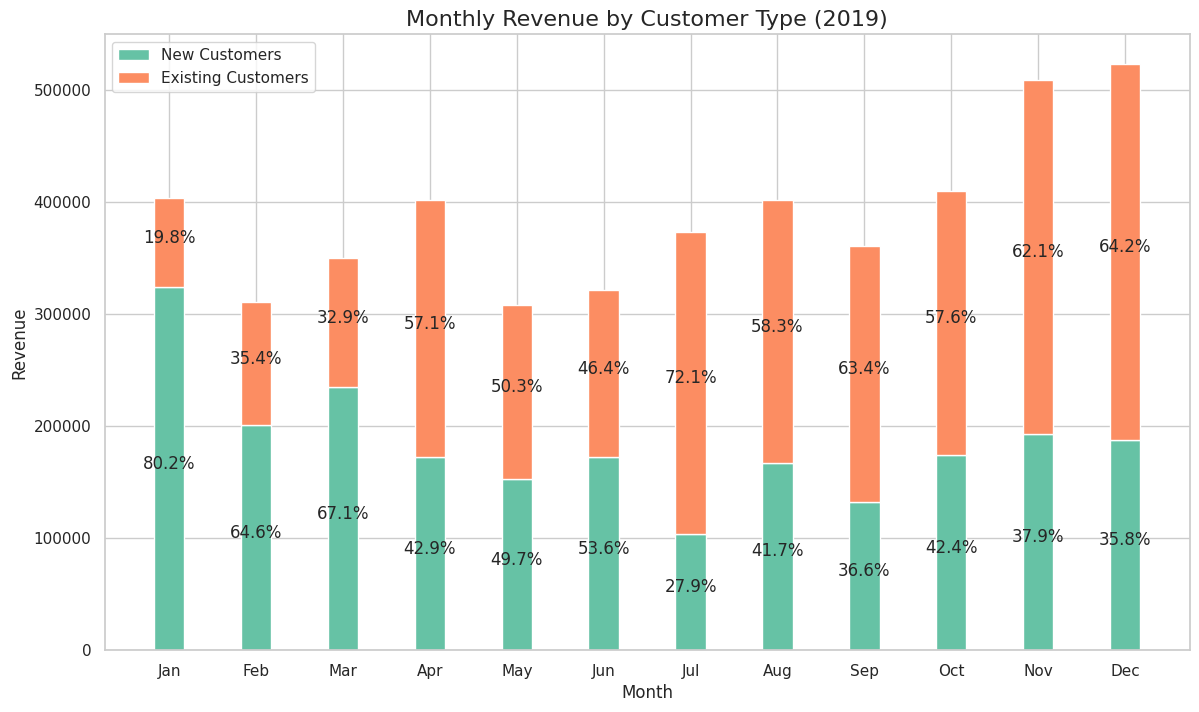

In [ ]:
def ques_4_revenue():
  # Monthly revenue by customer type
  # First merge sales with first purchase information to identify new vs existing customers
  sales_with_status = pd.merge(sales_df, first_purchase[['CustomerID', 'First_Purchase_Date']], on='CustomerID')
  # print(sales_with_status.head())
  sales_with_status['Customer_Type'] = np.where(
      sales_with_status['Transaction_Date'] == sales_with_status['First_Purchase_Date'],
      'New', 'Existing'
  )
  # print(sales_with_status.head())
  monthly_revenue = sales_with_status.groupby(['Month', 'Month_Name', 'Customer_Type'])['Revenue'].sum().reset_index()
  # print(monthly_revenue.head())
  monthly_revenue_pivot = monthly_revenue.pivot(index=['Month', 'Month_Name'],
                                                columns='Customer_Type',
                                                values='Revenue').reset_index().fillna(0)
  # print(monthly_revenue.head())
  # Calculate total monthly revenue and percentages
  monthly_revenue_pivot['Total_Revenue'] = monthly_revenue_pivot['New'] + monthly_revenue_pivot['Existing']
  monthly_revenue_pivot['New_Pct'] = monthly_revenue_pivot['New'] / monthly_revenue_pivot['Total_Revenue'] * 100
  monthly_revenue_pivot['Existing_Pct'] = monthly_revenue_pivot['Existing'] / monthly_revenue_pivot[
      'Total_Revenue'] * 100
  # print(monthly_revenue_pivot.head())
  # Sort by month
  monthly_revenue_pivot = monthly_revenue_pivot.sort_values('Month')

  total_new_revenue = monthly_revenue_pivot['New'].sum()
  total_existing_revenue = monthly_revenue_pivot['Existing'].sum()
  total_revenue = total_new_revenue + total_existing_revenue

  # Calculate percentages
  new_pct = total_new_revenue / total_revenue * 100
  existing_pct = total_existing_revenue / total_revenue * 100

  # Print results
  print(f"Total New Customer Revenue: ({new_pct:.2f}%)")
  print(f"Total Existing Customer Revenue:  ({existing_pct:.2f}%)")
  # Visualize monthly revenue by customer type
  plt.figure(figsize=(14, 8))
  x = monthly_revenue_pivot['Month_Name']
  width = 0.35
  plt.bar(x, monthly_revenue_pivot['New'], width, label='New Customers')
  plt.bar(x, monthly_revenue_pivot['Existing'], width, bottom=monthly_revenue_pivot['New'],
          label='Existing Customers')
  plt.title('Monthly Revenue by Customer Type (2019)', fontsize=16)
  plt.xlabel('Month')
  plt.ylabel('Revenue')
  plt.legend()
  # Add percentage text
  for i, (new, existing, total) in enumerate(zip(monthly_revenue_pivot['New'],
                                                  monthly_revenue_pivot['Existing'],
                                                  monthly_revenue_pivot['Total_Revenue'])):
      plt.text(i, new / 2, f"{new / total * 100:.1f}%", ha='center')
      plt.text(i, new + existing / 2, f"{existing / total * 100:.1f}%", ha='center')

ques_4_revenue()

In [ ]:


def ques_6_coupon_usage():
    # Analyze coupon impact on revenue
    coupon_revenue = sales_df.groupby('Coupon_Status')['Revenue'].agg(['sum', 'mean', 'count']).reset_index()
    coupon_revenue['Revenue_Share'] = coupon_revenue['sum'] / coupon_revenue['sum'].sum() * 100
    print("Revenue analysis by coupon usage:")
    print(coupon_revenue)

ques_6_coupon_usage()

Revenue analysis by coupon usage:
  Coupon_Status         sum       mean  count  Revenue_Share
0       Clicked  2377266.65  88.288890  26926      50.896407
1      Not Used   732709.87  90.525064   8094      15.687050
2          Used  1560818.10  87.177061  17904      33.416543


In [ ]:

def ques_7_top_products():
    # Identify top performing products
    top_products = sales_df.groupby(['Product_SKU', 'Product_Description', 'Product_Category']) \
        .agg(Total_Revenue=('Revenue', 'sum'),
             Units_Sold=('Quantity', 'sum'),
             Order_Count=('Transaction_ID', 'nunique'),
             Customer_Count=('CustomerID', 'nunique')) \
        .reset_index().sort_values('Total_Revenue', ascending=False)
    print("\nTop 10 products by revenue:")
    print(top_products.head(10)[['Product_Description', 'Product_Category', 'Total_Revenue', 'Units_Sold']])

ques_7_top_products()



Top 10 products by revenue:
                                   Product_Description Product_Category  \
981  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
983             Nest Cam Outdoor Security Camera - USA         Nest-USA   
976              Nest Cam Indoor Security Camera - USA         Nest-USA   
984    Nest Protect Smoke + CO White Battery Alarm-USA         Nest-USA   
985      Nest Protect Smoke + CO White Wired Alarm-USA         Nest-USA   
989       Nest Learning Thermostat 3rd Gen-USA - White         Nest-USA   
994        Nest Secure Alarm System Starter Pack - USA             Nest   
990                                  Nest Cam IQ - USA             Nest   
992                            Nest Thermostat E - USA             Nest   
980      Nest Learning Thermostat 3rd Gen-USA - Copper         Nest-USA   

     Total_Revenue  Units_Sold  
981      688916.34        4570  
983      629977.12        5206  
976      528612.93        4402  
984      2138


Product categories by revenue:
        Product_Category  Total_Revenue  Units_Sold
16              Nest-USA     2554202.39       21430
2                Apparel      591145.80       32438
14                  Nest      518193.50        2837
18                Office      276794.40       88383
6              Drinkware      200707.83       30501
4                   Bags      151314.43       15273
17  Notebooks & Journals      107085.96        9556
12             Lifestyle       74385.70       24881
15           Nest-Canada       70910.40         469
10              Headgear       53471.44        3533
8             Gift Cards       19533.82         206
9                 Google        9420.47         575
3              Backpacks        8772.69         113
0            Accessories        7295.88        1097
5                Bottles        6923.65        2090
19                  Waze        6311.94        1144
7                    Fun        6029.01         834
11            Housewares        

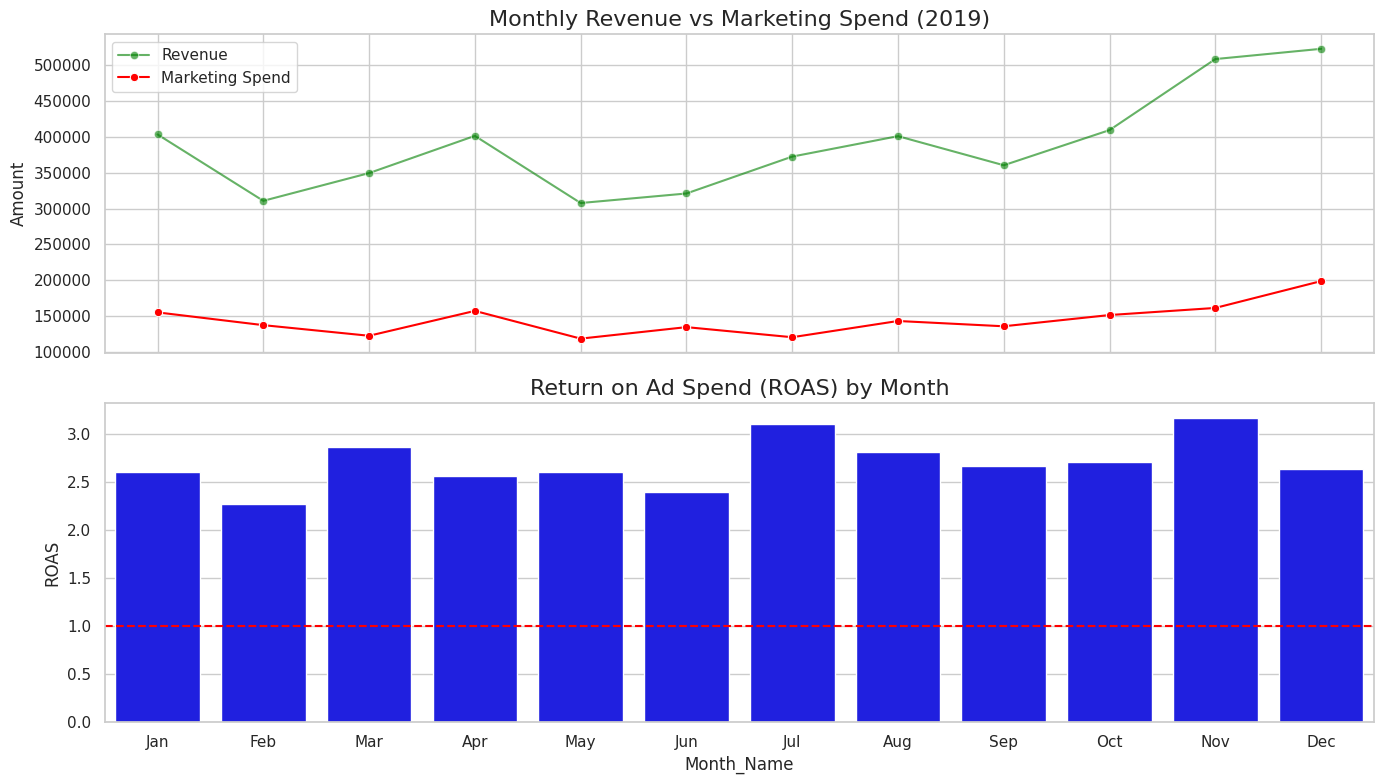

Month with highest ROAS: Nov with 3.16 ROAS
Month with lowest ROAS: Feb with 2.27 ROAS

Correlation matrix (Online Spend, Offline Spend, Revenue):
[[1.         0.87984094 0.8873844 ]
 [0.87984094 1.         0.79880062]
 [0.8873844  0.79880062 1.        ]]


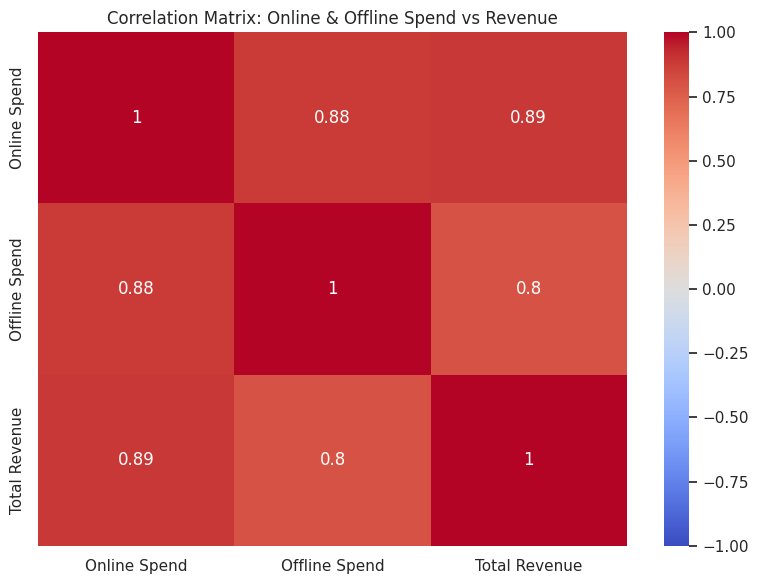

In [ ]:
def ques_8_9_marketing_spend_revenue():
    global correlation
    # Analyze top product categories
    top_categories = sales_df.groupby('Product_Category') \
        .agg(Total_Revenue=('Revenue', 'sum'),
             Units_Sold=('Quantity', 'sum'),
             Order_Count=('Transaction_ID', 'nunique'),
             Customer_Count=('CustomerID', 'nunique')) \
        .reset_index().sort_values('Total_Revenue', ascending=False)
    print("\nProduct categories by revenue:")
    print(top_categories[['Product_Category', 'Total_Revenue', 'Units_Sold']])
    # Calculate daily marketing metrics
    marketing_analysis = sales_marketing_df.copy()
    marketing_analysis['Total_Marketing_Spend'] = marketing_analysis['Offline_Spend'] + marketing_analysis[
        'Online_Spend']
    marketing_analysis['ROAS'] = marketing_analysis['Total_Revenue'] / marketing_analysis['Total_Marketing_Spend']
    # print(sales_marketing_df.info())
    # Aggregate to monthly level
    marketing_analysis['Month'] = marketing_analysis['Date'].dt.month
    marketing_analysis['Month_Name'] = marketing_analysis['Date'].dt.strftime('%b')
    monthly_marketing = marketing_analysis.groupby(['Month', 'Month_Name']).agg(
        Total_Revenue=('Total_Revenue', 'sum'),
        Offline_Spend=('Offline_Spend', 'sum'),
        Online_Spend=('Online_Spend', 'sum'),
        Total_Marketing_Spend=('Total_Marketing_Spend', 'sum'),
        Order_Count=('Order_Count', 'sum')
    ).reset_index()
    # Calculate monthly marketing metrics
    monthly_marketing['ROAS'] = monthly_marketing['Total_Revenue'] / monthly_marketing['Total_Marketing_Spend']
    monthly_marketing['CPO'] = monthly_marketing['Total_Marketing_Spend'] / monthly_marketing[
        'Order_Count']  # Cost Per Order
    monthly_marketing = monthly_marketing.sort_values('Month')
    # Visualize monthly marketing spend vs revenue
    # Set Seaborn style
    sns.set(style='whitegrid')
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    sns.lineplot(x='Month_Name', y='Total_Revenue', data=monthly_marketing, ax=axs[0], color='green', marker='o',
                 alpha=0.6,
                 label='Revenue')
    sns.lineplot(x='Month_Name', y='Total_Marketing_Spend', data=monthly_marketing, ax=axs[0], color='red', marker='o',
                 label='Marketing Spend')
    axs[0].set_title('Monthly Revenue vs Marketing Spend (2019)', fontsize=16)
    axs[0].set_ylabel('Amount')
    axs[0].legend()
    # --- Second subplot: ROAS ---
    sns.barplot(x='Month_Name', y='ROAS', data=monthly_marketing, ax=axs[1], color='blue')
    axs[1].set_title('Return on Ad Spend (ROAS) by Month', fontsize=16)
    axs[1].set_ylabel('ROAS')
    axs[1].axhline(y=1, color='red', linestyle='--')  # Reference line at ROAS = 1
    # Adjust layout
    plt.tight_layout()
    plt.show()
    # Identify months with highest and lowest ROAS
    highest_roas = monthly_marketing.loc[monthly_marketing['ROAS'].idxmax()]
    lowest_roas = monthly_marketing.loc[monthly_marketing['ROAS'].idxmin()]
    print(f"Month with highest ROAS: {highest_roas['Month_Name']} with {highest_roas['ROAS']:.2f} ROAS")
    print(f"Month with lowest ROAS: {lowest_roas['Month_Name']} with {lowest_roas['ROAS']:.2f} ROAS")
    # Analyze channel effectiveness
    monthly_marketing['Online_ROAS'] = monthly_marketing['Total_Revenue'] * monthly_marketing['Online_Spend'] / (
            monthly_marketing['Total_Marketing_Spend'] * monthly_marketing['Online_Spend'])
    monthly_marketing['Offline_ROAS'] = monthly_marketing['Total_Revenue'] * monthly_marketing['Offline_Spend'] / (
            monthly_marketing['Total_Marketing_Spend'] * monthly_marketing['Offline_Spend'])
    # Correlation analysis
    correlation = np.corrcoef([monthly_marketing['Online_Spend'],
                               monthly_marketing['Offline_Spend'],
                               monthly_marketing['Total_Revenue']])
    print("\nCorrelation matrix (Online Spend, Offline Spend, Revenue):")
    print(correlation)
    # Define labels for rows and columns
    labels = ['Online Spend', 'Offline Spend', 'Total Revenue']
    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                cmap='coolwarm',
                vmin=-1, vmax=1)
    plt.title('Correlation Matrix: Online & Offline Spend vs Revenue')
    plt.tight_layout()
    plt.show()

ques_8_9_marketing_spend_revenue()



Customer segment analysis:
    Segment  CustomerID     Recency  Frequency     Monetary  Customer_Pct
1   Premium         403   62.905707  40.518610  7467.195881     27.452316
0      Gold         307  140.342020  18.723127  3237.450261     20.912807
2    Silver         331  152.501511   8.966767  1397.266828     22.547684
3  Standard         427  221.018735   3.714286   480.379696     29.087193

Revenue contribution by segment:
    Segment     Revenue  Revenue_Pct
1   Premium  3009279.94    64.427580
0      Gold   993897.23    21.278975
2    Silver   462495.32     9.901855
3  Standard   205122.13     4.391590


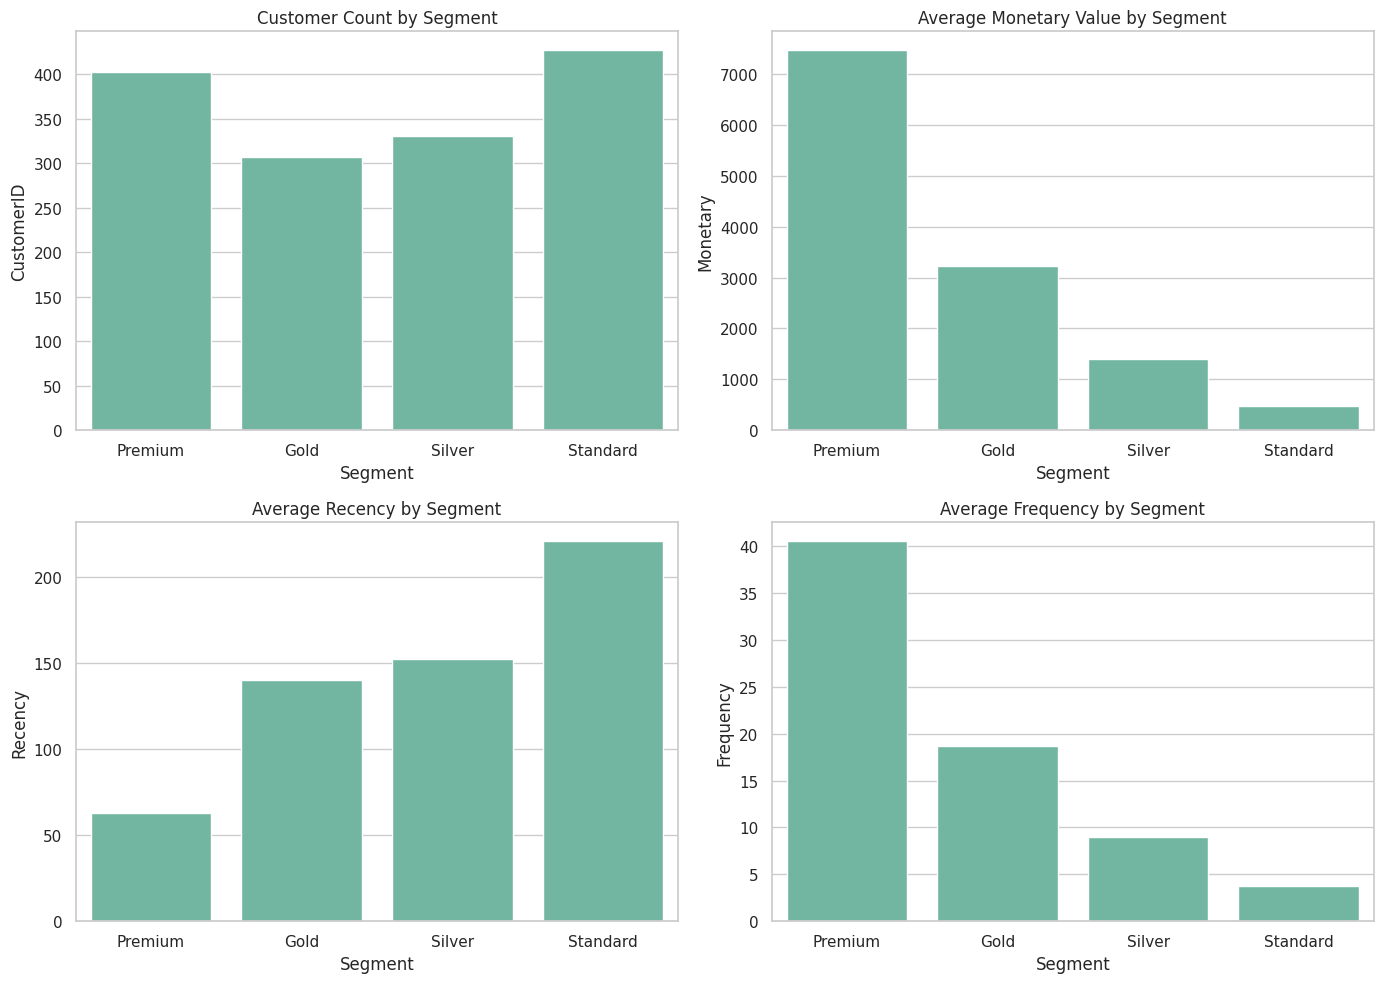

In [ ]:
def ques_10_11_segementation():
    global reference_date, rfm
    # Calculate RFM metrics
    # Set reference date (day after last transaction date)
    last_date = sales_df['Transaction_Date'].max()
    reference_date = last_date + timedelta(days=1)
    # Calculate RFM metrics for each customer
    rfm = sales_df.groupby('CustomerID').agg({
        'Transaction_Date': lambda x: (reference_date - x.max()).days,  # Recency
        'Transaction_ID': 'nunique',  # Frequency
        'Revenue': 'sum'  # Monetary
    }).reset_index()
    # print(rfm.head())
    # Rename columns
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    # Create RFM quartiles
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # Inverted (lower recency is better)
    rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4])
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
    # print(rfm.head())
    # Calculate RFM Score
    rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
    rfm['RFM_Sum'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

    # Define customer segments
    def segment_customer(row):
        if row['RFM_Sum'] >= 10:
            return 'Premium'
        elif row['RFM_Sum'] >= 8:
            return 'Gold'
        elif row['RFM_Sum'] >= 6:
            return 'Silver'
        else:
            return 'Standard'

    rfm['Segment'] = rfm.apply(segment_customer, axis=1)
    # print(rfm.head())
    # Analyze segments
    segment_analysis = rfm.groupby('Segment').agg({
        'CustomerID': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean'
    }).reset_index()
    segment_analysis['Customer_Pct'] = segment_analysis['CustomerID'] / segment_analysis['CustomerID'].sum() * 100
    segment_analysis = segment_analysis.sort_values('Monetary', ascending=False)
    # print(rfm.head())
    # Visualize customer segments
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    sns.barplot(x='Segment', y='CustomerID', data=segment_analysis)
    plt.title('Customer Count by Segment')
    plt.subplot(2, 2, 2)
    sns.barplot(x='Segment', y='Monetary', data=segment_analysis)
    plt.title('Average Monetary Value by Segment')
    plt.subplot(2, 2, 3)
    sns.barplot(x='Segment', y='Recency', data=segment_analysis)
    plt.title('Average Recency by Segment')
    plt.subplot(2, 2, 4)
    sns.barplot(x='Segment', y='Frequency', data=segment_analysis)
    plt.title('Average Frequency by Segment')
    plt.tight_layout()
    # Calculate segment revenue contribution
    # Merge RFM with sales data
    sales_with_segment = pd.merge(sales_df, rfm[['CustomerID', 'Segment']], on='CustomerID')
    segment_revenue = sales_with_segment.groupby('Segment')['Revenue'].sum().reset_index()
    segment_revenue['Revenue_Pct'] = segment_revenue['Revenue'] / segment_revenue['Revenue'].sum() * 100
    segment_revenue = segment_revenue.sort_values('Revenue', ascending=False)
    print("Customer segment analysis:")
    print(segment_analysis)
    print("\nRevenue contribution by segment:")
    print(segment_revenue)

    # Define function to get month number since first purchase
    def get_month_diff(d1, d2):
        return ((d1.year - d2.year) * 12 + d1.month - d2.month)

ques_10_11_segementation()


Average retention rates by month:
Month 0: 100.00%
Month 1: 9.68%
Month 2: 10.29%
Month 3: 10.89%
Month 4: 11.51%
Month 5: 14.66%
Month 6: 12.53%
Month 7: 13.37%
Month 8: 9.76%
Month 9: 11.74%
Month 10: 12.98%
Month 11: 15.81%


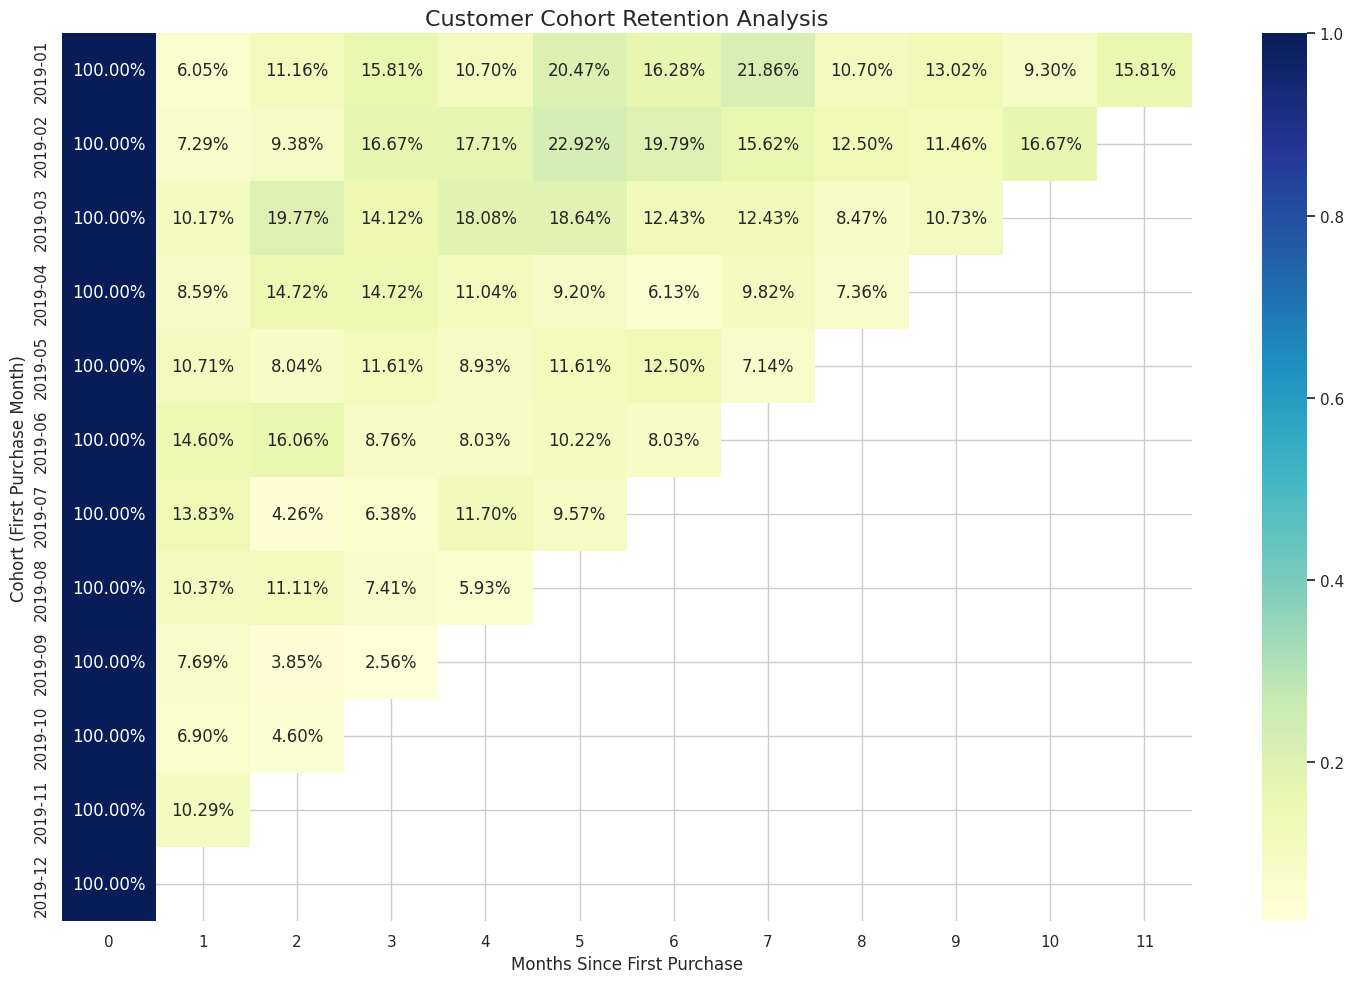

In [ ]:
def ques_12_13_cohort():
    global month
    # Create cohort based on first purchase month
    sales_with_cohort = pd.merge(sales_df, first_purchase[['CustomerID', 'First_Purchase_Date']], on='CustomerID')
    sales_with_cohort['Cohort_Month'] = sales_with_cohort['First_Purchase_Date'].dt.to_period('M')
    sales_with_cohort['Months_Since_First_Purchase'] = sales_with_cohort.apply(
        lambda x: get_month_diff(x['Transaction_Date'], x['First_Purchase_Date']), axis=1)
    # Count unique customers for each cohort and month
    cohort_data = sales_with_cohort.groupby(['Cohort_Month', 'Months_Since_First_Purchase'])[
        'CustomerID'].nunique().reset_index()
    cohort_pivot = cohort_data.pivot(index='Cohort_Month',
                                     columns='Months_Since_First_Purchase',
                                     values='CustomerID')
    # Calculate retention rates
    cohort_sizes = cohort_pivot[0]
    retention_pivot = cohort_pivot.divide(cohort_sizes, axis=0)
    # Visualize cohort retention
    plt.figure(figsize=(15, 10))
    sns.heatmap(retention_pivot, annot=True, fmt='.2%', cmap='YlGnBu')
    plt.title('Customer Cohort Retention Analysis', fontsize=16)
    plt.xlabel('Months Since First Purchase')
    plt.ylabel('Cohort (First Purchase Month)')
    plt.tight_layout()
    # Calculate average retention by month
    avg_retention = retention_pivot.mean(axis=0)
    print("Average retention rates by month:")
    for month, rate in avg_retention.items():
        print(f"Month {month}: {rate:.2%}")

ques_12_13_cohort()


In [ ]:

def ques_14_coupon_statistical_test():
    global t_stat, p_value
    print(sales_df.head())
    # Question 14: Do customers who use coupons have different average transaction values?
    coupon_yes = sales_df[sales_df['Coupon_Status'] == 'Used']['Revenue']
    coupon_no = sales_df[sales_df['Coupon_Status'] == 'Not Used']['Revenue']
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(coupon_yes, coupon_no, equal_var=False)
    print(f"Coupon usage t-test: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}")
    print(f"Mean transaction value with coupon: {coupon_yes.mean():.2f}")
    print(f"Mean transaction value without coupon: {coupon_no.mean():.2f}")
    print(f"Difference is {'statistically significant' if p_value < 0.05 else 'not statistically significant'}")

ques_14_coupon_statistical_test()


   CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679       2019-01-01  GGOENEBJ079499   
1       17850           16680       2019-01-01  GGOENEBJ079499   
2       17850           16681       2019-01-01  GGOEGFKQ020399   
3       17850           16682       2019-01-01  GGOEGAAB010516   
4       17850           16682       2019-01-01  GGOEGBJL013999   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  Year  Month  \
0         1     153.71               6.5          Used  2019      1   
1         1     153.71

In [ ]:
def ques_15_across_demographic():
    global sales_demographics, loc, p_value, t_stat
    # Question 15: Purchase behaviors across demographics
    sales_demographics = pd.merge(sales_df, customers_df, on='CustomerID')
    # Analyze by location
    location_stats = sales_demographics.groupby('Location').agg(
        Avg_Order_Value=('Revenue', lambda x: x.sum() / sales_demographics.groupby(['Location', 'Transaction_ID'])[
            'Revenue'].sum().count()),
        Orders_Per_Customer=('Transaction_ID', lambda x: x.nunique() / sales_demographics['CustomerID'].nunique()),
        Avg_Items_Per_Order=('Quantity', lambda x: x.sum() / x.count())
    ).reset_index()
    print("\nPurchase behavior by location:")
    print(location_stats)
    # ANOVA test for location differences
    location_groups = [sales_demographics[sales_demographics['Location'] == loc]['Revenue']
                       for loc in sales_demographics['Location'].unique()]
    f_stat, p_value = stats.f_oneway(*location_groups)
    print(f"Location ANOVA test: F-statistic = {f_stat:.3f}, p-value = {p_value:.4f}")
    print(
        f"Location differences are {'statistically significant' if p_value < 0.05 else 'not statistically significant'}")
    # Analyze by gender
    gender_stats = sales_demographics.groupby('Gender').agg(
        Avg_Order_Value=('Revenue', lambda x: x.sum() / sales_demographics.groupby(['Gender', 'Transaction_ID'])[
            'Revenue'].sum().count()),
        Orders_Per_Customer=('Transaction_ID', lambda x: x.nunique() / sales_demographics['CustomerID'].nunique()),
        Avg_Items_Per_Order=('Quantity', lambda x: x.sum() / x.count())
    ).reset_index()
    print("\nPurchase behavior by gender:")
    print(gender_stats)
    # T-test for gender differences
    gender_groups = [sales_demographics[sales_demographics['Gender'] == gender]['Revenue']
                     for gender in sales_demographics['Gender'].unique()]
    t_stat, p_value = stats.ttest_ind(*gender_groups, equal_var=False)
    print(f"Gender t-test: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}")

ques_15_across_demographic()



Purchase behavior by location:
        Location  Avg_Order_Value  Orders_Per_Customer  Avg_Items_Per_Order
0     California        55.143639             5.374659             4.497831
1        Chicago        62.156341             6.192098             4.568498
2     New Jersey        15.661246             1.545640             5.035976
3       New York        35.821647             3.745913             4.162445
4  Washington DC         9.777974             0.960490             4.503294
Location ANOVA test: F-statistic = 3.245, p-value = 0.0114
Location differences are statistically significant

Purchase behavior by gender:
  Gender  Avg_Order_Value  Orders_Per_Customer  Avg_Items_Per_Order
0      F       112.803319            10.879428             4.604205
1      M        68.650184             6.655313             4.321032
Gender t-test: t-statistic = 0.510, p-value = 0.6098



Correlation between tenure and purchase frequency: 0.010 (p-value: 0.7069)


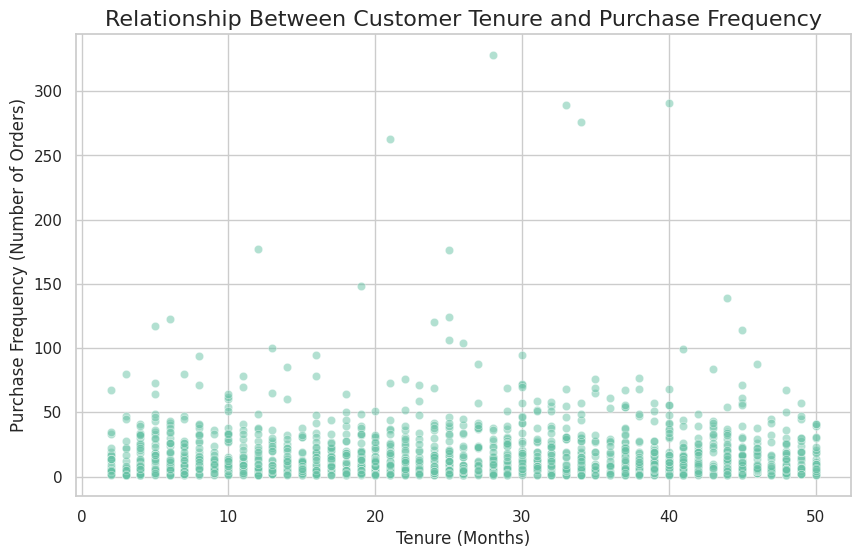

In [ ]:

def ques_16_tenure_frequency():
    global customer_purchase_freq
    # Question 16: Does customer tenure impact purchase frequency?
    # Calculate purchase frequency for each customer
    customer_purchase_freq = sales_df.groupby('CustomerID')['Transaction_ID'].nunique().reset_index()
    customer_purchase_freq.columns = ['CustomerID', 'Purchase_Frequency']
    # Merge with customer tenure information
    tenure_vs_frequency = pd.merge(customer_purchase_freq, customers_df[['CustomerID', 'Tenure_Months']],
                                   on='CustomerID')
    # Calculate correlation
    correlation, p_value = stats.pearsonr(tenure_vs_frequency['Tenure_Months'],
                                          tenure_vs_frequency['Purchase_Frequency'])
    print(f"\nCorrelation between tenure and purchase frequency: {correlation:.3f} (p-value: {p_value:.4f})")
    # Visualize relationship
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Tenure_Months', y='Purchase_Frequency', data=tenure_vs_frequency, alpha=0.5)
    plt.title('Relationship Between Customer Tenure and Purchase Frequency', fontsize=16)
    plt.xlabel('Tenure (Months)')
    plt.ylabel('Purchase Frequency (Number of Orders)')

ques_16_tenure_frequency()

In [ ]:

def ques_17_18_delivery_charges():
    global correlation, p_value
    # Question 17: Delivery charges impact on order behavior
    # Group transactions by delivery charge and analyze order behavior
    delivery_analysis = sales_df.groupby('Delivery_Charges').agg(
        Avg_Items_Per_Order=('Quantity', 'mean'),
        Avg_Order_Value=('Revenue', 'mean'),
        Order_Count=('Transaction_ID', 'nunique')
    ).reset_index()
    print("\nOrder behavior by delivery charge:")
    print(delivery_analysis)
    # Calculate correlation
    correlation, p_value = stats.pearsonr(sales_df['Delivery_Charges'], sales_df['Quantity'])
    print(f"Correlation between delivery charges and quantity ordered: {correlation:.3f} (p-value: {p_value:.4f})")

ques_17_18_delivery_charges()



Order behavior by delivery charge:
     Delivery_Charges  Avg_Items_Per_Order  Avg_Order_Value  Order_Count
0                0.00             1.314815       120.661975          158
1                6.00             2.981195        77.456471        12562
2                6.46             1.000000        32.990000            1
3                6.48             3.172414        14.662069            5
4                6.50             3.430179       102.037783         8719
..                ...                  ...              ...          ...
262            354.00            13.000000       343.070000            1
263            422.24            82.250000       652.857500            2
264            492.84            12.100000       135.847000            1
265            504.00           300.000000       780.625000            1
266            521.36           185.000000      1776.000000            1

[267 rows x 4 columns]
Correlation between delivery charges and quantity ordered: 0.191

   Day_of_Week Day_Name    Revenue
0            0      Mon  365626.90
1            1      Tue  396819.65
2            2      Wed  826622.00
3            3      Thu  840433.85
4            4      Fri  872004.86
5            5      Sat  673068.03
6            6      Sun  696219.33
   Day_of_Week Day_Name    Revenue
0            0      Mon  365626.90
1            1      Tue  396819.65
2            2      Wed  826622.00
3            3      Thu  840433.85
4            4      Fri  872004.86
5            5      Sat  673068.03
6            6      Sun  696219.33
New Year: Total Revenue = $98885.54, Daily Average = $14126.51, Compared to Overall Daily Average = $12796.70, Impact = 10.39%
Valentine's Day: Total Revenue = $105164.17, Daily Average = $13145.52, Compared to Overall Daily Average = $12796.70, Impact = 2.73%
Summer Sale: Total Revenue = $165137.09, Daily Average = $11009.14, Compared to Overall Daily Average = $12796.70, Impact = -13.97%
Back to School: Total Revenue = $371988.19, Dai

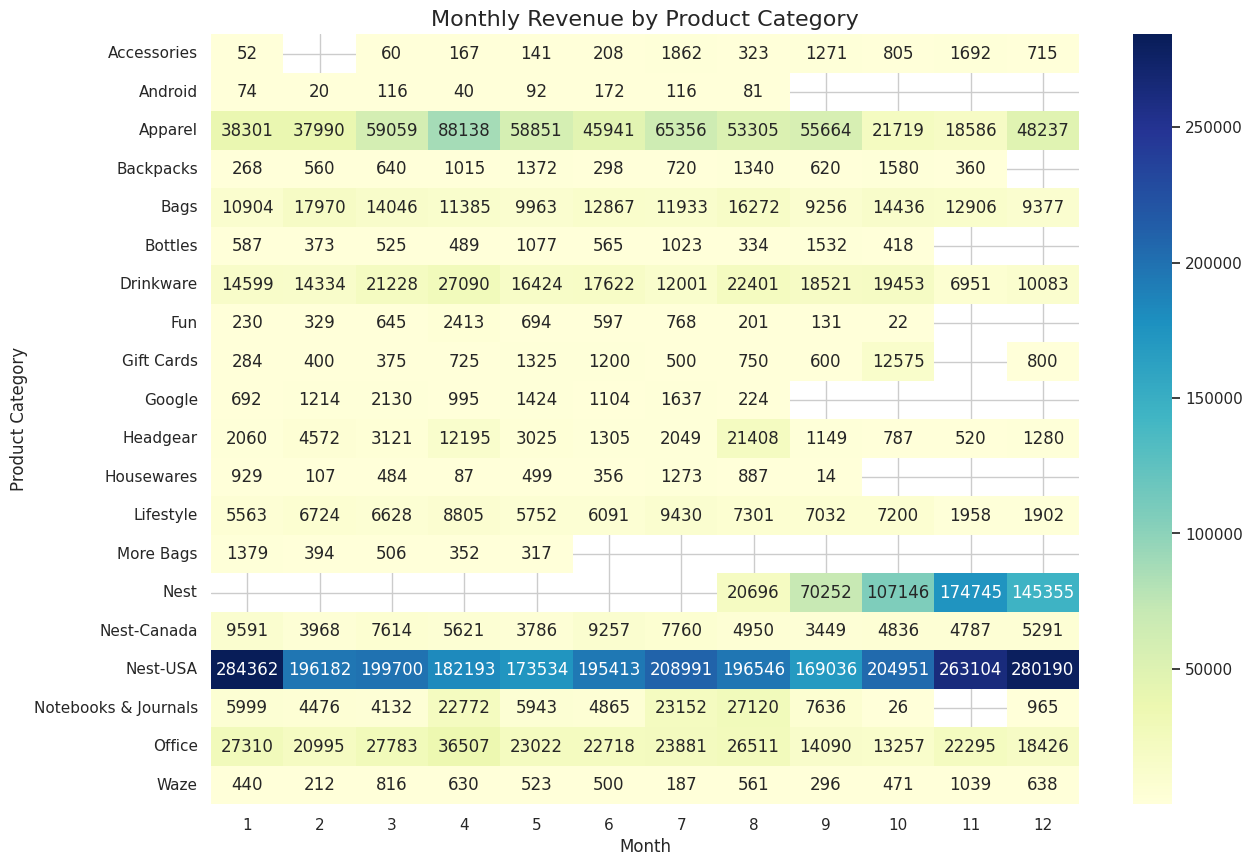

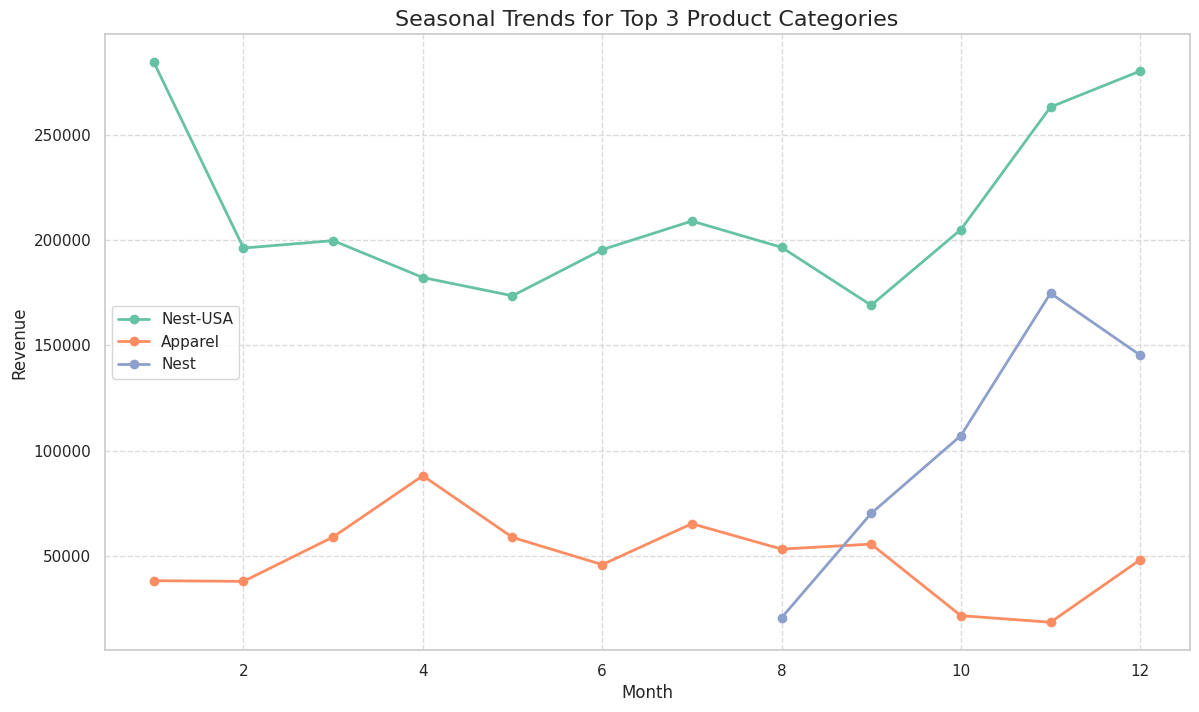

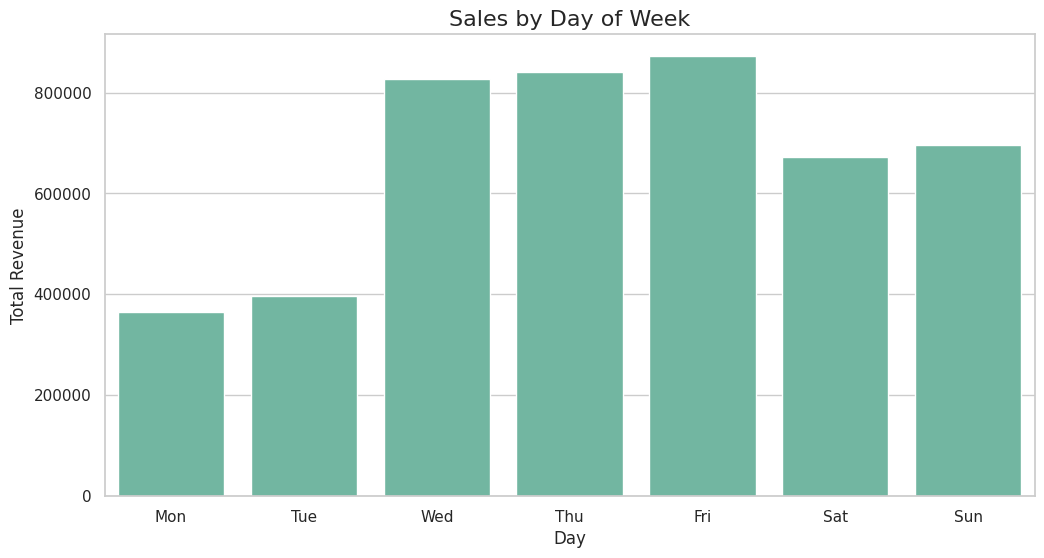

In [ ]:

def ques_19_20_seasonal_sales():
    # Analyze sales by category and month
    category_monthly_sales = sales_df.groupby(['Product_Category', 'Month', 'Month_Name'])[
        'Revenue'].sum().reset_index()
    # Create a heatmap of category sales by month
    category_month_pivot = category_monthly_sales.pivot(index='Product_Category',
                                                        columns='Month',
                                                        values='Revenue')
    plt.figure(figsize=(14, 10))
    sns.heatmap(category_month_pivot, cmap='YlGnBu', annot=True, fmt='.0f')
    plt.title('Monthly Revenue by Product Category', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Product Category')
    # Identify seasonal patterns for top categories
    top_3_categories = sales_df.groupby('Product_Category')['Revenue'].sum().nlargest(3).index
    plt.figure(figsize=(14, 8))
    for category in top_3_categories:
        category_data = category_monthly_sales[category_monthly_sales['Product_Category'] == category]
        plt.plot(category_data['Month'], category_data['Revenue'], marker='o', linewidth=2, label=category)
    plt.title('Seasonal Trends for Top 3 Product Categories', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    # Analyze sales by day of week
    daily_sales = sales_df.groupby(['Day_of_Week', 'Day_Name'])['Revenue'].sum().reset_index()
    daily_sales = daily_sales.sort_values('Day_of_Week')
    print(daily_sales)
    print(daily_sales)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Day_Name', y='Revenue', data=daily_sales)
    plt.title('Sales by Day of Week', fontsize=16)
    plt.xlabel('Day')
    plt.ylabel('Total Revenue')
    # Analyze holiday/special event impacts
    # Example: Identify potential holiday periods and check for sales spikes
    holiday_periods = {
        'New Year': ('2019-01-01', '2019-01-07'),
        'Valentine\'s Day': ('2019-02-07', '2019-02-14'),
        'Summer Sale': ('2019-07-01', '2019-07-15'),
        'Back to School': ('2019-08-15', '2019-09-15'),
        'Black Friday': ('2019-11-25', '2019-12-02'),
        'Holiday Season': ('2019-12-15', '2019-12-31')
    }
    for period_name, (start_date, end_date) in holiday_periods.items():
        period_sales = sales_df[(sales_df['Transaction_Date'] >= start_date) &
                                (sales_df['Transaction_Date'] <= end_date)]
        period_revenue = period_sales['Revenue'].sum()
        period_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
        period_daily_avg = period_revenue / period_days

        # Calculate average daily revenue for comparison
        overall_daily_avg = sales_df['Revenue'].sum() / ((sales_df['Transaction_Date'].max() -
                                                          sales_df['Transaction_Date'].min()).days + 1)

        print(f"{period_name}: Total Revenue = ${period_revenue:.2f}, " +
              f"Daily Average = ${period_daily_avg:.2f}, " +
              f"Compared to Overall Daily Average = ${overall_daily_avg:.2f}, " +
              f"Impact = {period_daily_avg / overall_daily_avg - 1:.2%}")

ques_19_20_seasonal_sales()
